In [1]:
import numpy as np
import os
import random

from matplotlib import pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf

from keras.models import Sequential, Model
from keras.models import load_model

from keras.applications.vgg16 import VGG16

from keras.layers import Flatten
from keras.layers import Flatten, Conv2D, MaxPooling2D, Dense, Concatenate, Dot, Lambda, Input

from keras.callbacks import History 

from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2

from keras.optimizers import Adam
from keras import backend as K

from sklearn.utils import shuffle

import h5py

create a dictionary mapping each missile model to their corresponding samples' filenames

In [2]:
missile_dir = r'C:\Users\Admin\few_shot_learning\main\data\missile'
missiles = os.listdir(missile_dir)
all_imgs_dir = {}

for missile in missiles:
    imgs_dir = r'{}\{}'.format(missile_dir, missile)
    imgs = os.listdir(imgs_dir)
    imgs = [r'{}\{}'.format(imgs_dir, fn.strip()) for fn in imgs]
    all_imgs_dir.update({missile : imgs})

print(missiles)

['aster', 'ihawk', 'spyder']


In [3]:
uav_dir = r'C:\Users\Admin\few_shot_learning\main\data\uav'
uavs = os.listdir(uav_dir)

for uav in uavs:
    imgs_dir = r'{}\{}'.format(uav_dir, uav)
    imgs = os.listdir(imgs_dir)
    imgs = [r'{}\{}'.format(imgs_dir, fn.strip()) for fn in imgs]
    all_imgs_dir.update({uav : imgs})

    print(uav)

hermes
heron


In [4]:
print(list(all_imgs_dir.keys()))
print(all_imgs_dir['aster'][0])

['aster', 'ihawk', 'spyder', 'hermes', 'heron']
C:\Users\Admin\few_shot_learning\main\data\missile\aster\2Q__ (1).jpg


In [15]:
def pad_img(img, desired_ratio):
    height = img.shape[0]
    width = img.shape[1]

    try:
    
        channels = img.shape[2]

    except IndexError:
        # img is a single channel image -> convert to rgb space
        img = cv2.merge((img,img,img))
    
    if img.shape[2] == 4:
        # img has alpha channel -> convert to rgb space
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

    aspect_ratio = width / height

    if aspect_ratio > desired_ratio:
        # image is too 'long' -> pad the top and bottom
        required_height = width / desired_ratio
        required_padding = int((required_height - height) // 2)
        
        padded_img = cv2.copyMakeBorder(img, top = required_padding, bottom = required_padding, left = 0, right = 0, borderType = cv2.BORDER_CONSTANT)

    elif aspect_ratio < desired_ratio:
        # image is too 'tall' -> pad the sides
        required_width = height * desired_ratio
        required_padding = int((required_width - width) // 2)
        
        padded_img = cv2.copyMakeBorder(img, top = 0, bottom = 0, left = required_padding, right = required_padding, borderType = cv2.BORDER_CONSTANT)
    else:
        # image is perfect ratio -> no padding required
        return img

    return padded_img

def pad_and_resize(img, desired_ratio, width, height):

    padded_img = pad_img(img, desired_ratio)
    result = cv2.resize(padded_img, (width, height))
    return result


Test the above function!

(194, 259, 3)
(260, 390, 3)
<class 'numpy.ndarray'>


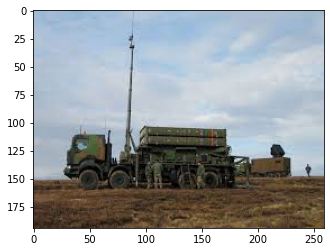

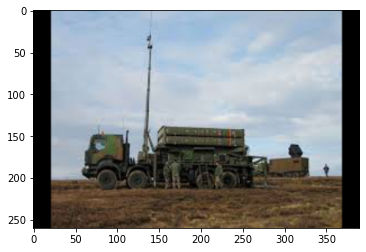

In [6]:
img = plt.imread(all_imgs_dir['aster'][5])
plt.figure()
plt.imshow(img)
print(img.shape)

plt.figure()
new_img = pad_and_resize(img, desired_ratio=1.5, width=390, height=260)
plt.imshow(new_img)
print(new_img.shape)
print(type(new_img))

simple, unscientific scan of the common aspect ratios in our dataset reveals that most images have 1.5 ratio

In [7]:
ratios = []
widths = []
heights = []
for missile, imgs in all_imgs_dir.items():
    for im in imgs:
        img  = plt.imread(im)
        ratios.append(img.shape[1]/img.shape[0])
        widths.append(img.shape[1])
        heights.append(img.shape[0])

print(sum(ratios)/ len(ratios))
print(sum(widths)/ len(widths))
print(sum(heights)/ len(heights))



1.570266643508157
362.22392026578075
236.2498338870432


In [21]:
def save_data(**kwargs):
    # save it once to allow load from file

    # train_pairs, train_labels and X_test all contain 0s and 1s which can be converted to unsigned 8 bit ints
    # use np.astype(np.uint8) to convert array before saving

    print('saving data...')
    for key, value in kwargs.items():

        with h5py.File('preprocess/{}.h5'.format(key), 'w') as hf:

           if type(value).__module__ == np.__name__:

                # train_pairs and X_test are image sets which are just 0s and 1s
                # train_labels also contain only 0s and 1s which 
                # can be converted to unsigned 8 bit ints
                # use np.astype(np.uint8) to convert array before saving

                value = value.astype(np.uint8)
                hf.create_dataset(key, value.shape, h5py.h5t.STD_U8BE, data = value)
                
                print('saved {} to /preprocess/{}.h5!'.format(key, key))

           else:

                # If data is a list of strings
                dt = h5py.special_dtype(vlen=str) 
                value = np.array(value, dtype=dt) 
                hf.create_dataset(key, data = value)

                print('saved {} to /preprocess/{}.h5!'.format(key, key))
            
    
    return None

#load from file
def load_data(**kwargs):

    all_data = {}

    for key, value in kwargs.items():

        if value:

            with h5py.File('preprocess/{}.h5'.format(key), 'r') as hf:

                if type(hf[key][0]) == bytes:
             
                    data = [item.decode('utf8') for item in hf[key][:]] # convert from bytes to str
                else:
                    data = hf[key][:]

                all_data.update({key : data}) 
                print('{} loaded from /preprocess/{}.h5!'.format(key, key))

    return all_data

convert all our images into 3 channel images with padding (if needed) and resized to our desired dimensions

In [16]:
def get_all_X_Y(all_imgs_dir):
    
    X = np.array([])
    Y = []
    count = 0

    for label, fns in all_imgs_dir.items():
        for fn in fns:
            img = plt.imread(fn)
            new_img = pad_and_resize(img, desired_ratio=1.5, width=390, height=260)
        
            if X.size == 0:
                X = np.array([new_img])
                Y.append(label)
                continue

            try:
                X = np.vstack((X, [new_img]))
                Y.append(label)  

            except Exception as e:
                print(e)
                print(fn)
            
            if count % 200 == 0:
                print(count)

            count += 1
    
    return X, Y

In [17]:
X, Y = get_all_X_Y(all_imgs_dir)
print(X.shape)
print(len(Y))

0
200
400
600
800
1000
1200
1400
(1505, 260, 390, 3)
1505


In [24]:
# Y = [y.decode('utf-8') for y in Y]
print(type(Y[0]))
Y[0]
save_data(Y=Y)

<class 'str'>
saving data...
saved Y to /preprocess/Y.h5!


In [27]:
kwargs = {'X' : True,
          'Y' : True
        }
data = load_data(**kwargs)

X loaded from /preprocess/X.h5!
Y loaded from /preprocess/Y.h5!


In [40]:
X = data['X']
Y = data['Y']
print(X.shape)
print(len(Y), type(Y[0]))

(1505, 260, 390, 3)
1505 <class 'str'>


In [98]:
def make_pairs(X, Y, unique):

    # this function will produce < 2*len(X) pairs if unique=True as it will not allow the same image to be used twice
    # also if unique=True the # of positive samples most likely != # of negative samples

    pairs = []
    labels = []
    raw_labels = []
    chosen_j = []

    if unique:
        exclude_j = []

    for i in range(len(X)):
        if i % 100 == 0:
            print(i)
        # choose a matching sample
        x1 = X[i]
        class_ = Y[i]

        # get possible indices where x2 is same class as x1
        if unique:
            J = [j for j, y in enumerate(Y) if y == class_ and not j in exclude_j]
        else:
            J = [j for j, y in enumerate(Y) if y == class_]

        if len(J) != 0:
            

            j = np.random.choice(J)
            chosen_j.append(j)

            if unique:
                exclude_j.append(j)

            x2 = X[j]

            pairs += [[x1, x2]]
            labels += [1]

            raw_labels += [[Y[i], Y[j]]]

        # get non-match
        # get possible indices where x2 is different from x1
        if unique:
            J = [j for j, y in enumerate(Y) if y != class_ and not j in exclude_j]
        else:
            J = [j for j, y in enumerate(Y) if y != class_]

        if len(J) != 0:
            

            j = np.random.choice(J)
            chosen_j.append(j)

            if unique:
                exclude_j.append(j)

            x2 = X[j]

            pairs += [[x1, x2]]
            labels += [0]
            raw_labels += [[Y[i], Y[j]]]
        
    return np.array(pairs), np.array(labels), np.array(raw_labels), chosen_j

In [99]:
all_pairs, all_labels, raw_labels, chosen_j = make_pairs(X, Y, unique=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [100]:
print(all_pairs.shape)
print(all_labels.shape)
print(raw_labels.shape)
print(len(chosen_j))


(3010, 2, 260, 390, 3)
(3010,)
(3010, 2)
3010


In [101]:
save_data(all_pairs=all_pairs, all_labels=all_labels)
save_data(raw_labels=raw_labels.tolist())

saving data...
saved all_pairs to /preprocess/all_pairs.h5!
saved all_labels to /preprocess/all_labels.h5!
saving data...
saved raw_labels to /preprocess/raw_labels.h5!


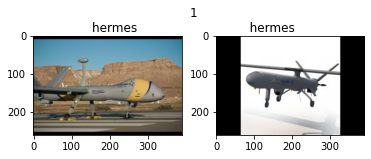

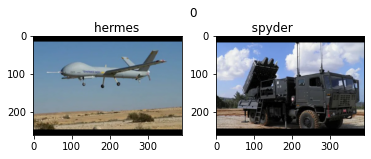

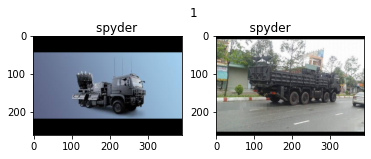

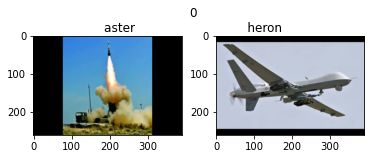

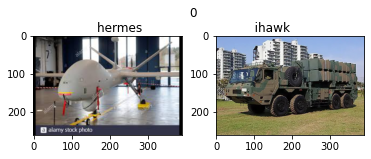

In [103]:
for i in range(5):
    
    fig = plt.figure()
    rand_i = np.random.randint(0, len(all_labels))
    fig.suptitle('{}\n{}                             {}'.format(all_labels[rand_i], raw_labels[rand_i][0], raw_labels[rand_i][1]))
    plt.subplot(2,2,1)
    plt.imshow(all_pairs[rand_i][0])
    plt.subplot(2,2,2)
    plt.imshow(all_pairs[rand_i][1])

In [65]:
def get_pretrained_model(input_shape):
    """
        Model architecture
    """

    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Convolutional Neural Network
    pre_train = Sequential()
    base = VGG16(include_top=False, input_shape=input_shape)

    # freeze all layers but last 4
    for layer in base.layers[:-4]:
        layer.trainable = False
    
    pre_train.add(base)
    pre_train.add(tf.keras.layers.Flatten())
    embedding = Model(pre_train.input, pre_train.output, name="Embedding")
    
    

    # Generate the encodings (feature vectors) for the two images
    encoded_l = embedding(left_input)
    encoded_r = embedding(right_input)
    
 
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
  

    # # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer='zeros')(L1_distance)


    # # Connect the inputs with the outputs
    pretrained_model = Model(inputs=[left_input,right_input], outputs=prediction)

    # return the model
    return pretrained_model

model = get_pretrained_model((260, 390, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 250, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200, 250, 3) 0                                            
__________________________________________________________________________________________________
Embedding (Functional)          (None, 21504)        14714688    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 21504)        0           Embedding[0][0]              

split our dataset twice to get training, testing and validation sets

In [104]:
all_train_pairs, test_pairs, all_train_labels, test_labels = train_test_split(all_pairs, all_labels, test_size=0.2, random_state=42)

train_pairs, val_pairs, train_labels, val_labels = train_test_split(all_train_pairs, all_train_labels, test_size=0.2, random_state=50)
val_inputs = [val_pairs[:,0], val_pairs[:,1]]
print(train_pairs.shape, val_pairs.shape, test_pairs.shape)

(1926, 2, 260, 390, 3) (482, 2, 260, 390, 3) (602, 2, 260, 390, 3)
